#Introduction

This is a stock price prediction project where we will be using the historical Bank NIFTY data of past 10 years to make a model that can predict the Opening prices of the future stocks. We would use a multivariate LSTM model (whose hyperparameter tuning is left for now).

#Importing Necessary Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

#Importing the Data File

In [2]:
from google.colab import files
uploaded = files.upload()

Saving nse.csv to nse.csv


In [32]:
import io

df = pd.read_csv(io.BytesIO(uploaded['nse.csv']))
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,03-Jan-2011,11882.10,11912.15,11826.95,11855.75,8895927,909.29
1,04-Jan-2011,11868.40,11872.80,11545.55,11564.05,16041214,1949.98
2,05-Jan-2011,11545.75,11545.75,11265.55,11305.45,19689201,1988.86
3,06-Jan-2011,11350.70,11377.10,11164.75,11186.80,19559984,2114.13
4,07-Jan-2011,11146.45,11258.50,11007.90,11053.35,25192954,2746.05


In [33]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Shares Traded',
       'Turnover (Rs. Cr)'],
      dtype='object')

In [34]:
Dates = df["Date"]
df.set_index("Date", inplace = True)
df.drop(columns = ['Shares Traded', 'Turnover (Rs. Cr)'], inplace = True)

In [35]:
df.dtypes

Open     float64
High     float64
Low      float64
Close    float64
dtype: object

In [36]:
df.head()

,Open,High,Low,Close
Date,,,,
03-Jan-2011,11882.10,11912.15,11826.95,11855.75
04-Jan-2011,11868.40,11872.80,11545.55,11564.05
05-Jan-2011,11545.75,11545.75,11265.55,11305.45
06-Jan-2011,11350.70,11377.10,11164.75,11186.80
07-Jan-2011,11146.45,11258.50,11007.90,11053.35


In [ ]:
df.describe()

,Open,High,Low,Close
count,2584.000000,2584.000000,2584.000000,2584.000000
mean,19173.983785,19325.218247,18991.752593,19158.387248
std,7396.127876,7438.691657,7337.439429,7389.489445
min,7948.450000,7961.700000,7766.350000,7798.550000
25%,11622.737500,11742.050000,11534.237500,11633.787500
50%,18448.350000,18602.825000,18287.125000,18443.400000
75%,25390.200000,25498.225000,25149.012500,25335.400000
max,37492.600000,37708.750000,36764.250000,37306.250000


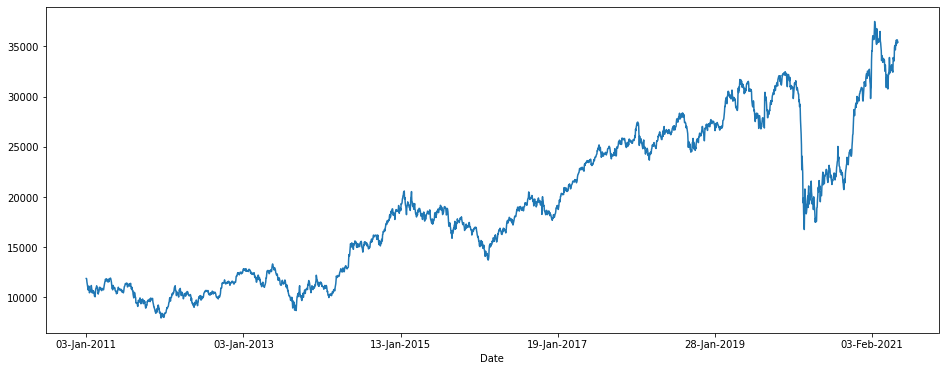

In [ ]:
df["Open"].plot(figsize = (16,6))

#Scalers

In [115]:
mm_scaler = MinMaxScaler(feature_range = (0, 1))
std_scaler = StandardScaler() 

#Splitting Function

This function splits the dataset into training and testing dataset while respecting the order of Time Series

In [6]:
def split(dft, split_ratio = 0.75, random_state = 4):
  train_size = int(split_ratio * len(dft))
  test_size = len(dft) - train_size
  train_data = dft[0:train_size,:]
  test_data = dft[train_size:len(dft)]

  return train_data, test_data

#Dataset Matrix

This function converts the data into the working format. For our workable format, we are using past 60 days data to predict the data for the 61th day.

In [7]:
def data_matrix(dft, n_future = 10, n_past = 60):
  x = []
  y = []
  for i in range(n_past, len(dft) - n_future + 1):
    x.append(dft[i - n_past:i])
    y.append(dft[i:(i + n_future), 0])

  return np.array(x), np.array(y)

##Function check

In [12]:
xt, yt = data_matrix(df, n_future = 10, n_past = 60)
print(xt.shape)
print(yt.shape)

TypeError: ignored

In [ ]:
xt

array([[[11882.1 , 11912.15, 11826.95, 11855.75],
        [11868.4 , 11872.8 , 11545.55, 11564.05],
        [11545.75, 11545.75, 11265.55, 11305.45],
        ...,
        [11179.2 , 11420.4 , 11136.45, 11387.3 ],
        [11348.85, 11599.  , 11348.15, 11523.4 ],
        [11522.75, 11657.6 , 11507.45, 11582.5 ]],

       [[11868.4 , 11872.8 , 11545.55, 11564.05],
        [11545.75, 11545.75, 11265.55, 11305.45],
        [11350.7 , 11377.1 , 11164.75, 11186.8 ],
        ...,
        [11348.85, 11599.  , 11348.15, 11523.4 ],
        [11522.75, 11657.6 , 11507.45, 11582.5 ],
        [11625.5 , 11801.65, 11625.5 , 11765.2 ]],

       [[11545.75, 11545.75, 11265.55, 11305.45],
        [11350.7 , 11377.1 , 11164.75, 11186.8 ],
        [11146.45, 11258.5 , 11007.9 , 11053.35],
        ...,
        [11522.75, 11657.6 , 11507.45, 11582.5 ],
        [11625.5 , 11801.65, 11625.5 , 11765.2 ],
        [11804.95, 11898.4 , 11569.25, 11705.45]],

       ...,

       [[36371.55, 36656.2 , 35584.6 , 358

#Defining the LSTM model

In [8]:
def LSTM_model(x, y, lstm_layers = 2, hidden_units=[64, 32], dropout = 0.2, act = ["tanh", "tanh"]):
  model = Sequential()
  for i in range(lstm_layers):
    if (i == 0):
      model.add(LSTM(hidden_units[i], activation= act[i], input_shape = (x.shape[1], x.shape[2]), return_sequences = True))
    elif (i== lstm_layers-1):
      model.add(LSTM(hidden_units[i], activation=act[i], return_sequences = False))
    else:
      model.add(LSTM(hidden_units[i], activation=act[i], return_sequences = True))
    
  model.add(Dropout(dropout))
  model.add(Dense(y.shape[1]))

  model.compile(loss = 'mean_squared_error', optimizer = 'adam')
  model.summary()

  return model


##check

In [ ]:
Model = LSTM_model(xt, yt, lstm_layers  = 2, hidden_units = [64, 32], dropout = 0.3)

In [ ]:
fitted = Model.fit(xt, yt, epochs = 10, batch_size = 32, verbose=1, validation_split=0.15)

Epoch 1/10
67/67 [==============================] - 6s 52ms/step - loss: 1679364352.0000 - val_loss: 1213362176.0000
Epoch 2/10
67/67 [==============================] - 3s 48ms/step - loss: 865854400.0000 - val_loss: 10670977024.0000
Epoch 3/10
67/67 [==============================] - 3s 48ms/step - loss: 2875963904.0000 - val_loss: 1000353536.0000
Epoch 4/10
67/67 [==============================] - 3s 47ms/step - loss: 443678784.0000 - val_loss: 517981024.0000
Epoch 5/10
67/67 [==============================] - 3s 47ms/step - loss: 225486656.0000 - val_loss: 288885184.0000
Epoch 6/10
67/67 [==============================] - 3s 48ms/step - loss: 966415104.0000 - val_loss: 242681568.0000
Epoch 7/10
67/67 [==============================] - 3s 48ms/step - loss: 182375088.0000 - val_loss: 191483984.0000
Epoch 8/10
67/67 [==============================] - 3s 48ms/step - loss: 693309120.0000 - val_loss: 450224576.0000
Epoch 9/10
67/67 [==============================] - 3s 48ms/step - loss: 1

#Using MinMaxScaler and then training

In [116]:
#Using scale() to scale the data
df_scaled = mm_scaler.fit_transform(df)

#Using split() to split the dataset into train and test set
df_train, df_test = split(df_scaled, split_ratio=0.75)

#Using data_matrix() to convert train and test data into input data matrix
x_train, y_train = data_matrix(df_train, n_future = 1, n_past = 60)
x_test, y_test = data_matrix(df_test, n_future = 1, n_past = 60)

#Creating a model using LSTM_model()
Model = LSTM_model(x_train, y_train, lstm_layers=3, hidden_units=[64, 32, 20], dropout = 0.25, act = ['tanh', 'tanh', 'tanh'])

#Fitting the data
fitted = Model.fit(x_train, y_train, batch_size = 64, epochs = 50, verbose = 1, validation_split= 0.15 )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60, 64)            17664     
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 32)            12416     
_________________________________________________________________
lstm_11 (LSTM)               (None, 20)                4240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 34,341
Trainable params: 34,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
25/25 [==============================] - 7s 109ms/step - loss: 0.0120 - val_loss: 0.0022
Epoch 2/50
25/25

In [124]:
train_pred = Model.predict(x_train)
test_pred = Model.predict(x_test)

##check

In [39]:
train_pred.shape

(1878, 1)

In [40]:
y_train.shape

(1878, 1)

In [41]:
train_pred

array([[0.10975119],
       [0.11305219],
       [0.11684225],
       ...,
       [0.55855083],
       [0.5594566 ],
       [0.5594465 ]], dtype=float32)

#Score

In [125]:
train_mse = math.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

print("Training set RMSE: ", train_mse)
print("Training set R2: ", train_r2)

test_mse = math.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)
print("Testing set RMSE: ", test_mse)
print("Testing set R2: ", test_r2)

Training set RMSE:  0.020252962125923948
Training set R2:  0.9885393035728911
Testing set RMSE:  0.054898484050138995
Testing set R2:  0.8816883491188503


#Getting predictions

In [126]:
y_pred = np.array(train_pred[-60:])
y_pred = y_pred.reshape(-1)
y_pred.shape

(60,)

In [127]:
temp = np.array(test_pred)
temp = temp.reshape(-1)
y_pred = np.concatenate((y_pred, temp))
y_pred.shape

(646,)

In [128]:
y_pred = y_pred.reshape((-1,1))
y_pred.shape

(646, 1)

In [129]:
y_pred = np.repeat(y_pred, 4,axis=1)
y_pred.shape

(646, 4)

In [130]:
y_pred

array([[0.6138147 , 0.6138147 , 0.6138147 , 0.6138147 ],
       [0.61536074, 0.61536074, 0.61536074, 0.61536074],
       [0.6179629 , 0.6179629 , 0.6179629 , 0.6179629 ],
       ...,
       [0.8519904 , 0.8519904 , 0.8519904 , 0.8519904 ],
       [0.8554668 , 0.8554668 , 0.8554668 , 0.8554668 ],
       [0.8581376 , 0.8581376 , 0.8581376 , 0.8581376 ]], dtype=float32)

#Final Results

In [131]:
y_pred = mm_scaler.inverse_transform(y_pred)[:,0]
y_pred = y_pred.reshape((-1,1))
y_pred.shape

(646, 1)

In [132]:
forecast_open = []

for i in range(len(df_train)):
  forecast_open.append(np.nan)
print(len(forecast_open))

for y in y_pred:
  forecast_open.append(y)

forecast_open = np.array(forecast_open).reshape((-1))

print(len(df_train))
print(forecast_open.shape)

1938
1938
(2584,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [101]:
df["Open"].shape

(2584,)

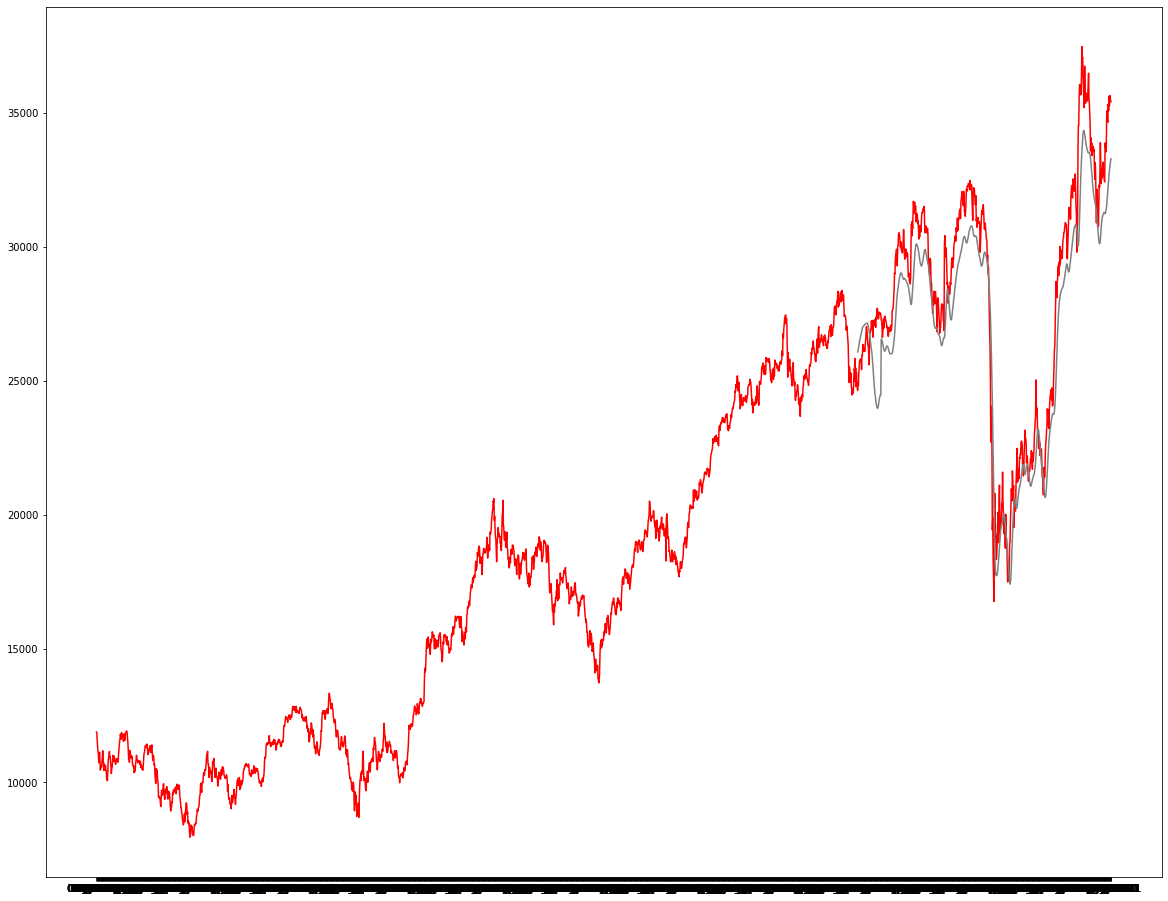

In [133]:
plt.figure(figsize=(20,16))
plt.plot(Dates, df["Open"], color = "red")
plt.plot(Dates, forecast_open, color = "grey")

In [134]:
Final_RMSE = math.sqrt(mean_squared_error(y_pred, df["Open"][-len(y_pred):]))
Final_R2 = r2_score(y_pred,df["Open"][-len(y_pred):])

print("Final RMSE: ", Final_RMSE)
print("Final R2: ", Final_R2)

Final RMSE:  1649.2917836117113
Final R2:  0.8339348934807919
